# Integration & Quadrature

First, let's recall a few definitions.  An indefinite integral is an integral without bounds, and is defined up to a constant
\begin{equation}
\int x\, dx = \frac{x^2}{2} + C
\end{equation}
A definite integral has bounds, which are sometimes symbolic
\begin{equation}
\int_0^y 1\, dx = y
\end{equation}

## Symbolic Integration

`sympy` includes a variety of functionality for integration.

In [1]:
import sympy as sym
x, y = sym.symbols('x y')

You can compute indefinite integrals

In [2]:
sym.integrate(1, x) 

x

In [3]:
sym.integrate(x**2 + x - 1)

x**3/3 + x**2/2 - x

In [4]:
sym.integrate(x*y, y)

x*y**2/2

If you want to compute definite integrals, you can pass in the bounds

In [5]:
sym.integrate(1, (x, 0, 2))

2

In [6]:
sym.integrate(sym.sin(x), (x, 0, sym.pi))

2

In [7]:
sym.integrate(x*y, (y, 0, 1))

x/2

In [8]:
sym.integrate(x, (x, 0, y))

y**2/2

SymPy also provides integral transforms such as the Fourier transform

In [9]:
k = sym.Symbol('k')
sym.fourier_transform(sym.exp(-x**2), x, k)

sqrt(pi)*exp(-pi**2*k**2)

You can find more complete information in the [sympy documentation](https://docs.sympy.org/latest/modules/integrals/integrals.html)

## Numerical Integration (Quadrature)

Numerical integration is used to obtain definite integrals.

First, we should recall the definition of the Riemannian integral:
\begin{equation}
\int_a^b f(x)\, dx = \lim_{n\to \infty} \frac{b-a}{n}\sum_{i=1}^n f(x_i) (x_{i+1} - x_i)
\end{equation}
where the sequence $\{x_i\}$ is built for each $n$ so that $x_{i+1} - x_{i} = (b-a)/n$.  It is useful to think of how integrals compute area under a curve.  In this case, we are (approximately) computing this area as the sum of rectangles with height $f(x_i)$ and width $x_{i+1}-x_i$.  More generally, we can think of this as a weighted sum of function values
\begin{equation}
\sum_{i=1}^n f(x_i) w_i
\end{equation}
Which looks more like Lesbegue integration, where $w_i$ is the measure assigned to the point $x_i$.

In order to numerically integrate functions, we will take a finite sum of weighted function values, where the weights and function evaluation points are designed to give a good approximation to the integral.  This is known as [quadrature](https://en.wikipedia.org/wiki/Quadrature_(mathematics)) (instead of inegration).

### Trapezoidal Rule

One of the simplest quadrature rules is trapezoid rule, which approximates an area under a curve by trapezoids defined by the four points $(x_i,0), (x_{i+1},0), (x_i, f(x_i)), (x_{i+1}, f(x_{i+1}))$.  The area of this trapezoid is 
\begin{equation}
\frac{1}{2}\bigg(f(x_{i+1}) + f(x_i)\bigg)(x_{i+1} - x_i)
\end{equation}
If we have $a = x_0 \le x_1 \le ... \le x_{n} = b$ equally spaced, then the quadrature weights for $x_i$ are $w_i = (b-a)/n$ if $i\notin \{0,n\}$, and $w_i= (b-a)/(2n)$ if $i \in \{0,n\}$

You can use trapezoid rule in `scipy` using [`scipy.integrate.trapz`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapz.html#scipy.integrate.trapz)

In [10]:
import numpy as np
from scipy.integrate import trapz

x = np.linspace(0,1,100)
y = x**2
trapz(y, x) # actual answer is 1/3

0.33335033840084355

Other quadrature rules that you can use easily are Simpson's rule (`simps`) and Romberg's rule (`romb`)

In [11]:
from scipy.integrate import simps

simps(y,x) # again, answer is 1/3

0.333333505101692

### Gaussian Quadrature

Gaussian quadrature computes points `x_i` and weights `w_i` to optimally integrate polynomials up to some fixed order.  This is all wrapped up in `fixed_quad` or `quadrature` functions

In [15]:
from scipy.integrate import fixed_quad, quadrature

f = lambda x: x**10

`fixed_quad` integrates up to fixed polynomial order

In [17]:
1/11

0.09090909090909091

In [20]:
fixed_quad(f, 0, 1, n=11) # n is order of polynomial

(0.09090909090909102, None)

The return tuple is the computed result and `None`.

`quadrature` integrates up to a fixed tolerance

In [21]:
quadrature(f, 0, 1)

(0.09090909090909097, 1.1102230246251565e-16)

In [25]:
for ifunction in (fixed_quad, quadrature):
    print(ifunction(f, 0, 1)[0])

0.09090765936004021
0.09090909090909097


The return tuple is the computed result and the error, measured as the difference between the last two estimates.

### General Quadrature

The function [`quad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) wraps a varitety of functionality.  Basic use is just like above

In [26]:
from scipy.integrate import quad

f = lambda x: x**2

quad(f, 0, 1)

(0.33333333333333337, 3.700743415417189e-15)

Again, the function returns the computed result, and an estimate of the absolute error.

You can also compute integrals on unbounded domains

In [27]:
f = lambda x: np.exp(-x**2)

quad(f, 0, np.inf)

(0.8862269254527579, 7.101318390472462e-09)

### Functions with Discontinuities

Discontinuities can cause problems with any sort of quadrature scheme that assumes functions are continuous.  You can specify problematics points with `points`

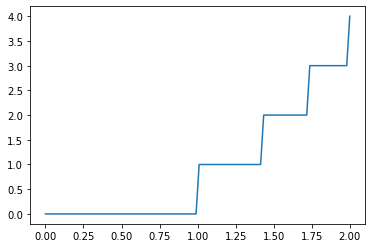

In [29]:
import matplotlib.pyplot as plt

f = lambda x : np.floor(x**2)

x = np.linspace(0,2,100)
plt.plot(x, f(x))
plt.show()

In [30]:
quad(f, 0, 2)

(1.8537356322944702, 9.277312917888025e-09)

In [31]:
quad(f, 0, 2, points=np.sqrt(np.arange(5)))

(1.8537356300580277, 2.0580599780584437e-14)

### Functions with Singularities

Depending on the type of singularity, you can pass in different arguments into the `weight` and `wvar` parameters of `quad`.  See [the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) for details.

For example, let's say we want to compute

\begin{equation}
\int_{-1}^2 \frac{1}{x}\,dx
\end{equation}

<ipython-input-45-74bd56e45931>:1: RuntimeWarning: divide by zero encountered in true_divide
  f = lambda x : 1 / x


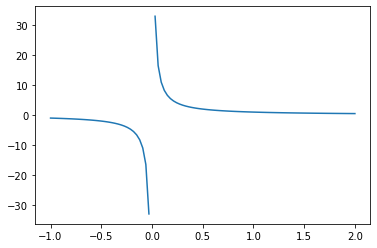

In [45]:
f = lambda x : 1 / x

x = np.linspace(-1,2,100)
plt.plot(x, f(x))
plt.show()

There is an odd symmetry in the interval $[-1,1]$, so we can calculate

\begin{equation}
\int_{-1}^2 \frac{1}{x}\,dx = \int_1^2 \frac{1}{x}\,dx = \log(2) - \log(1) = \log(2)
\end{equation}

The `'cauchy'` weight will calculate the integral of $\frac{f(x)}{x - {\tt wvar}}$ (i.e. we will weight the fuction $f$ by the Cauchy distribution $\frac{1}{x - {\tt wvar}}$).

So we can use `weight='cauchy'` with `wvar=0` on the function `f(x) = 1` to compute our integral.


In [43]:
quad(lambda x : 1, -1, 2, weight='cauchy', wvar=0) # mulitply function by 1/x and do integration

(0.6931471805599452, 0.0)

In [44]:
np.log(2)

0.6931471805599453

## Multivariate Integration

You can integrate over functions of multiple variables using
* [`dblquad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html#scipy.integrate.dblquad) for 2 variables
* [`tplquad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.tplquad.html#scipy.integrate.tplquad) for 3 variables
* [`nquad`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.nquad.html#scipy.integrate.nquad) for `n` variables

`nquad` integrates over a hyper cube defined by ranges in the second argument. `dblquad` and `tplquad` can allow you to integrate over more complicated domains.

In [38]:
from scipy.integrate import nquad

f = lambda x, y, z : np.exp( -x**2 - y**2 - z**2)

nquad(f, ((-3,3), (-3,3), (-3,3)))

(5.56795898358481, 1.4605401208842099e-08)

## Monte Carlo Integration

[Monte Carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration) is a method which computes integrals by taking a sum over random samples. 

\begin{equation}
\int_{a}^b f(x) = \mathbb{E}_{U(a,b)} [f]
\end{equation}

Where $U(a,b)$ is the uniform distribution over the interval $[a,b]$. We can estimate this expected value by drawing samples from the distribution, and computing

\begin{equation}
\mathbb{E}_{U(a,b)} [f] \approx \frac{1}{N} \sum_{i=1}^N f(x_i), x_i \sim U(a,b)
\end{equation}

Or, more generally, we might define an integral over a probability measure $\mu$

\begin{equation}
\int f(x)\, d\mu(x) = \mathbb{E}_{\mu} [f] = \frac{1}{N} \sum_{i=1}^N f(x_i), x_i \sim \mu(x)
\end{equation}

The expected error can be derived from the law of large numbers, and is typically $\frac{1}{\sqrt{N}}$.  In high dimensions, this is typically the most effictive way to integrate functions, as quadrature requires a number of samples that is exponential in terms of the dimension.

### Example

The classic example of Monte Carlo integration is computing $\pi$ using random samples.  Recall the area of the unit circle is $\pi$, and the area of the square $[-1,1]^2$ is $4$.  We sample points uniformly from this square, and compute how many fall in the unit circle - the expected ratio of points inside the circle to the total number of points is $\pi/4$.

In [41]:
def compute_pi_mc(n=1000):
    x = np.random.rand(n,2)*2 - 1 # sampled in [-1,1] x [-1,1]
    r = np.linalg.norm(x, axis=1) # computes radius of each point
    return 4 * np.sum(r <= 1.) / n

In [42]:
%time compute_pi_mc(10_000_000)

CPU times: user 416 ms, sys: 40.6 ms, total: 456 ms
Wall time: 455 ms


3.1411008

We can use numba to parallelize this

In [26]:
from numba import njit

@njit
def compute_pi_mc_numba(n=1000):
    x = np.random.rand(n,2)*2 - 1
    ct = 0
    for i in range(n):
        ct += x[i,0]**2 + x[i,1]**2 < 1
    return 4 * ct / n

In [28]:
%time compute_pi_mc_numba(10_000_000)

CPU times: user 257 ms, sys: 107 ms, total: 364 ms
Wall time: 366 ms


3.141374

In [29]:
from numba import njit, prange

@njit(parallel=True)
def compute_pi_mc_numba_parallel(n=1000):
    x = np.random.rand(n,2)*2 - 1
    ct = 0
    for i in prange(n):
        ct += x[i,0]**2 + x[i,1]**2 < 1
    return 4 * ct / n

In [31]:
%time compute_pi_mc_numba_parallel(10_000_000)

CPU times: user 492 ms, sys: 170 ms, total: 662 ms
Wall time: 136 ms


3.1422112

if we look at the wall time, we see this runs faster than any of the other options